參考網站
https://blog.jiatool.com/posts/job104_spider/
https://tlyu0419.github.io/2020/06/19/Crawler-104HumanResource/

In [19]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import re
import time
import os
from IPython.display import clear_output
import re, time, requests
from selenium import webdriver
from bs4 import BeautifulSoup

In [319]:
import time
import random
import requests


class Job104Spider():
    def search(self,keyword, max_mun=1000, filter_params=filter_params, sort_type='符合度', is_sort_asc=False):
        """搜尋職缺"""
        jobs = []
        total_count = 0

        url = 'https://www.104.com.tw/jobs/search/list'
        query = f'ro=0&kwop=7&keyword={keyword}&expansionType=area,spec,com,job,wf,wktm&mode=s&jobsource=2018indexpoc'
        if filter_params:
            # 加上篩選參數，要先轉換為 URL 參數字串格式
            query += ''.join([f'&{key}={value}' for key, value, in filter_params.items()])

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.92 Safari/537.36',
            'Referer': 'https://www.104.com.tw/jobs/search/',
        }

        # 加上排序條件
        sort_dict = {
            '符合度': '1',
            '日期': '2',
            '經歷': '3',
            '學歷': '4',
            '應徵人數': '7',
            '待遇': '13',
        }
        sort_params = f"&order={sort_dict.get(sort_type, '1')}"
        sort_params += '&asc=1' if is_sort_asc else '&asc=0'
        query += sort_params

        page = 1
        while len(jobs) < max_mun:
            params = f'{query}&page={page}'
            r = requests.get(url, params=params, headers=headers)
            if r.status_code != requests.codes.ok:
                print('請求失敗', r.status_code)
                data = r.json()
                print(data['status'], data['statusMsg'], data['errorMsg'])
                break

            data = r.json()
            total_count = data['data']['totalCount']
            jobs.extend(data['data']['list'])

            if (page == data['data']['totalPage']) or (data['data']['totalPage'] == 0):
                break
            page += 1
            time.sleep(random.uniform(3, 5))

        return total_count, jobs[:max_mun]

    def get_job(self, job_id):
        """取得職缺詳細資料"""
        url = f'https://www.104.com.tw/job/ajax/content/{job_id}'

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.92 Safari/537.36',
            'Referer': f'https://www.104.com.tw/job/{job_id}'
        }

        r = requests.get(url, headers=headers)
        if r.status_code != requests.codes.ok:
            print('請求失敗', r.status_code)
            return

        data = r.json()
        return data['data']

    def search_job_transform(self, job_data):
        """將職缺資料轉換格式、補齊資料"""
        appear_date = job_data['appearDate']
        apply_num = int(job_data['applyCnt'])
        company_addr = f"{job_data['jobAddrNoDesc']} {job_data['jobAddress']}"

        job_url = f"https:{job_data['link']['job']}"
        job_company_url = f"https:{job_data['link']['cust']}"
        job_analyze_url = f"https:{job_data['link']['applyAnalyze']}"

        job_id = job_url.split('/job/')[-1]
        if '?' in job_id:
            job_id = job_id.split('?')[0]

        salary_high = int(job_data['salaryLow'])
        salary_low = int(job_data['salaryHigh'])
        ohter = job104_spider.get_job(job_id)
        job_info = ohter['condition']['other']
        welfare = ohter['welfare']['tag']
        
        job = {
            'job_id': job_id,
            'type': job_data['jobType'],
            'name': job_data['jobName'],  # 職缺名稱
            # 'desc': job_data['descSnippet'],  # 描述
            'appear_date': appear_date,  # 更新日期
            'apply_num': apply_num,
            'apply_text': job_data['applyDesc'],  # 應徵人數描述
            'company_name': job_data['custName'],  # 公司名稱
            'company_addr': company_addr,  # 工作地址
            'job_url': job_url,  # 職缺網頁
            'job_analyze_url': job_analyze_url,  # 應徵分析網頁
            'job_company_url': job_company_url,  # 公司介紹網頁
            #'lon': job_data['lon'],  # 經度
            #'lat': job_data['lat'],  # 緯度
            'education': job_data['optionEdu'],  # 學歷
            'period': job_data['periodDesc'],  # 經驗年份
            'salary': job_data['salaryDesc'],  # 薪資描述
            'salary_high': salary_high,  # 薪資最高
            'salary_low': salary_low,  # 薪資最低
            'tags': job_data['tags'],  # 標籤
            'description': job_data['descSnippet'],  # 職位內容
            'Other description': job_info,  # 其他
            'welfare': welfare  # welfare
            
        }
        return job


if __name__ == "__main__":
    job104_spider = Job104Spider()

    filter_params = {
        'area': '6001001000,6001008000',  # (地區) 台北市,台中市
        's9': '1',  # (上班時段) 日班
        #'isnew': '0',  # (更新日期) 本日最新
        # 's9': '1,2,4,8',  # (上班時段) 日班,夜班,大夜班,假日班
        's5': '0',  # 0:不需輪班 256:輪班
        'wktm': '1',  # (休假制度) 週休二日
        'isnew': '14',  # (更新日期) 0:本日最新 3:三日內 7:一週內 14:兩週內 30:一個月內
        'jobexp': '1,3,5,10',
        #'1,3,5,10,99', (經歷要求) 1年以下,1-3年,3-5年,5-10年,10年以上
        # 'newZone': '1,2,3,4,5',  # (科技園區) 竹科,中科,南科,內湖,南港
        'zone': '5,4',
        #'16',  # (公司類型) 16:上市上櫃 5:外商一般 4:外商資訊
        # 'wf': '1,2,3,4,5,6,7,8,9,10',  # (福利制度) 年終獎金,三節獎金,員工旅遊,分紅配股,設施福利,休假福利,津貼/補助,彈性上下班,健康檢查,團體保險
        'edu': '4,5,6',
        "keyword": "Data",
        #'1,2,3,4,5,6',  # (學歷要求) 高中職以下,高中職,專科,大學,碩士,博士
        'remoteWork': '1',  # (上班型態) 1:完全遠端 2:部分遠端
        'excludeJobKeyword': '科技',  # 排除關鍵字
        'kwop': '1',  # 只搜尋職務名稱
    }
    total_count, jobs = job104_spider.search('python', max_mun=10, filter_params=filter_params)

    print('搜尋結果職缺總數：', total_count)
    # print(len(jobs))
    jobs = [job104_spider.search_job_transform(job) for job in jobs]
    print(jobs[0])


    #job_info = job104_spider.get_job('6k4sv')
    #print(job_info)
    
   
#df.to_csv('list.csv', index=False, encoding='utf_8_sig')

搜尋結果職缺總數： 1
{'job_id': '3wt4u', 'type': '1', 'name': '【零售採購總部】採購供應鏈管理師 Supply Chain Management', 'appear_date': '20211015', 'apply_num': 87, 'apply_text': '大於30人應徵', 'company_name': 'DECATHLON法商迪卡儂_台灣迪卡儂有限公司', 'company_addr': '台中市南屯區 大墩南路379號', 'job_url': 'https://www.104.com.tw/job/3wt4u?jobsource=hotjob_chr', 'job_analyze_url': 'https://www.104.com.tw/jobs/apply/analysis/3wt4u?channel=104rpt&jobsource=hotjob_chr', 'job_company_url': 'https://www.104.com.tw/company/1a2x6bil6e?jobsource=hotjob_chr', 'education': '大學', 'period': '2年以上', 'salary': '待遇面議', 'salary_high': 0, 'salary_low': 0, 'tags': ['外商公司', '員工1000人'], 'description': '【OUR PURPOSE】\nWE MAKE SPORTS ACCESSIBLE FOR THE MANY.\n\n【MY OBJECTIVE】\nI make products available for stores &amp; E-commerce and ensure a profitable growth in my universe by optimizing the supply chain management.\n\n【MY RESPONSIBILITIES】\n- I am responsible for the accuracy of products referencing in my scope.\n- I contribute to user satisfaction in stor

In [320]:
df = pd.DataFrame(jobs)
df

,job_id,type,name,appear_date,apply_num,apply_text,company_name,company_addr,job_url,job_analyze_url,job_company_url,education,period,salary,salary_high,salary_low,tags,description,Other description,welfare
0,3wt4u,1,【零售採購總部】採購供應鏈管理師 Supply Chain Management,20211015,87,大於30人應徵,DECATHLON法商迪卡儂_台灣迪卡儂有限公司,台中市南屯區 大墩南路379號,https://www.104.com.tw/job/3wt4u?jobsource=hot...,https://www.104.com.tw/jobs/apply/analysis/3wt...,https://www.104.com.tw/company/1a2x6bil6e?jobs...,大學,2年以上,待遇面議,0,0,"[外商公司, 員工1000人]",【OUR PURPOSE】\nWE MAKE SPORTS ACCESSIBLE FOR T...,"- Passionate about sports, practicing regularl...","[員工認股, 三節獎金/禮品, 不扣薪病假, 員工優惠, 優於勞基法特休]"
1,7eup0,1,Senior Climate Change and Energy Officer,20211014,79,大於30人應徵,英國在台辦事處,台北市信義區 松高路9-11號26樓,https://www.104.com.tw/job/7eup0?jobsource=hot...,https://www.104.com.tw/jobs/apply/analysis/7eu...,https://www.104.com.tw/company/1wjsduw?jobsour...,大學,3年以上,"月薪76,143元",76143,76143,[外商公司],Main purpose of job:\n\nThe British Office Tai...,Resources managed (staff):\nYou will manage th...,[]
2,6fnov,1,【生產管理總部】自行車部門採購供應鏈管理師 Cycle Supply Production ...,20211015,23,11~30人應徵,DECATHLON法商迪卡儂_台灣迪卡儂有限公司,台中市南屯區,https://www.104.com.tw/job/6fnov?jobsource=hot...,https://www.104.com.tw/jobs/apply/analysis/6fn...,https://www.104.com.tw/company/1a2x6bil6e?jobs...,專科,2年以上,待遇面議,0,0,"[外商公司, 員工1000人]",YOUR RESPONSIBILITIES:\n1.You decide the best ...,Who you are:\nYou are passionate by Sport and ...,"[員工認股, 三節獎金/禮品, 不扣薪病假, 員工優惠, 優於勞基法特休]"
3,5yf1w,1,DRAM Product Engineer [DRAM產品工程師][R&amp;D研發],20211004,67,大於30人應徵,台灣美光(台灣美光晶圓科技股份有限公司/台灣美光記憶體股份有限公司/美商美光亞太科技股份有限...,台中市后里區 三豐路4段369號,https://www.104.com.tw/job/5yf1w?jobsource=hot...,https://www.104.com.tw/jobs/apply/analysis/5yf...,https://www.104.com.tw/company/10ww9gpk?jobsou...,大學,經歷不拘,待遇面議,0,0,"[上市上櫃, 外商公司, 員工9000人]",As a DRAM Engineering Group (DEG) Product Engi...,Education\nRequired: Bachelors Degree above: E...,[]
4,6t8g2,1,【採線上面談】Business Analyst 商業分析師(台北),20211014,10,6~10人應徵,新加坡商鈦坦科技股份有限公司台灣分公司,台北市南港區 園區街3之1號11樓之1（南港軟體園區G棟）,https://www.104.com.tw/job/6t8g2?jobsource=hot...,https://www.104.com.tw/jobs/apply/analysis/6t8...,https://www.104.com.tw/company/1a2x6bin60?jobs...,高中,2年以上,待遇面議,0,0,"[外商公司, 員工280人]",What a Business Analyst does in Titansoft\n\n•...,What makes a (Super!) Business Analyst in Tita...,[]
5,7aqei,2,Senior Data Engineer【資深資料工程師】,20211020,0,0~5人應徵,Arc &amp; Codementor_皮爾愛迪亞有限公司,台北市中正區 新生南路1段50號7樓之7,https://www.104.com.tw/job/7aqei?jobsource=jol...,https://www.104.com.tw/jobs/apply/analysis/7aq...,https://www.104.com.tw/company/1a2x6bjh0h?jobs...,大學,經歷不拘,"年薪1,000,000~1,800,000元",1000000,1800000,"[外商公司, 員工50人, 遠端工作]",[About us]\n在投遞履歷之前，Arc &amp; Codementor 工程師徵才...,,"[零食櫃, 咖啡吧, 部門聚餐, 優於勞基法特休, 可遠距/在家上班]"
6,6w9pc,3,Python大數據工程師(短期3個月),20211020,2,0~5人應徵,網飛訊科技股份有限公司,台北市中山區 視專案所在位置而定，最遠不超過雙北市,https://www.104.com.tw/job/6w9pc?jobsource=job...,https://www.104.com.tw/jobs/apply/analysis/6w9...,https://www.104.com.tw/company/60ikxs0?jobsour...,專科,3年以上,待遇面議,0,0,[員工30人],工作內容：\n參與電信業大數據應用程式開發(Kafka &amp; Spark)專案。\n\...,,[]
7,7dpwf,3,(資深)資料工程師 (Senior) Data Engineer,20211015,3,0~5人應徵,果實夥伴股份有限公司,台北市內湖區 瑞光路610號2樓,https://www.104.com.tw/job/7dpwf?jobsource=job...,https://www.104.com.tw/jobs/apply/analysis/7dp...,https://www.104.com.tw/company/b8w975s?jobsour...,大學,1年以上,待遇面議,0,0,[員工80人],【工作內容 】\n- ETL 之開發、處理(資料清理、儲存、分析)與監測\n- 依據不同業...,【 加分條件】\n- 1年以上數據資料處理相關經驗\n- 對網站運作熟悉，GA、GTM、網站...,"[年終獎金, 三節獎金/禮品, 零食櫃, 員工舒壓按摩, 不扣薪病假, 結婚禮金, 生育津貼..."
8,7dg32,3,大數據工程師Big Data Engineer,20211021,2,0~5人應徵,英屬維京群島商易貿創投有限公司台灣分公司,台北市松山區 敦化北路170號5樓A室,https://www.104.com.tw/job/7dg32?jobsource=job...,https://www.104.com.tw/jobs/apply/analysis/7dg...,https://www.104.com.tw/company/1a2x6blbqz?jobs...,大學,3年以上,待遇面議,0,0,[員工270人],Job Responsibility：\n1. 大數據基礎技術方向、hadoop生態體系開發...,1.熟悉Hadoop/Flink/Spark/YARN/HDFS/Kafka等常用的大資料存...,"[年終獎金, 三節獎金/禮品, 生日假]"
9,6uceh,3,(LINE Bank) Data Engineer_資料工程師,20211022,11,11~30人應徵,LINE Bank_連線商業銀行股份有限公司,台北市內湖區 瑞光路333號3樓,https://www.104.com.tw/job/6uceh?jobsource=j

In [278]:
df.to_csv('list.csv', index=False, encoding='utf_8_sig')

PermissionError: [Errno 13] Permission denied: 'list.csv'

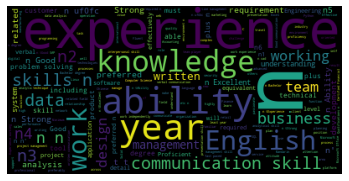

In [264]:
# -*- coding: utf-8 -*-
import nltk
from wordcloud import WordCloud
text = df['Other description'].values 
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()